In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import datetime as dt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(64).shuffle(50000)
train_dataset = train_dataset.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
train_dataset = train_dataset.repeat()
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(5000).shuffle(10000)
valid_dataset = valid_dataset.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
valid_dataset = valid_dataset.repeat()



def res_net_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu',
                      padding='same')(input_data)
    x = layers.BatchNormalization(axis = -1)(x)
    x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = layers.BatchNormalization(axis = -1)(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    return x

def non_res_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu',
                      padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
num_res_net_blocks = 10
for i in range(num_res_net_blocks):
    x = res_net_block(x, 64, 3)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)
res_net_model = keras.Model(inputs, outputs)


callbacks = [
    # Write TensorBoard logs to `./logs` directory
    keras.callbacks.TensorBoard(
        log_dir='./log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")), write_images=True),
]
res_net_model.compile(optimizer=keras.optimizers.Adam(),
                        loss='sparse_categorical_crossentropy',
                        metrics=['acc'])

print(res_net_model.summary())

checkpoint = ModelCheckpoint('Model.hdf5', monitor='val_loss', save_best_only = True, verbose=1, mode='min')

callbacks_list = [checkpoint]
#model.load_weights('Model.hdf5')
epochs = 10
results = res_net_model.fit(train_dataset, epochs=30, steps_per_epoch=195,
                    validation_data=valid_dataset,
                    validation_steps=3, callbacks=callbacks_list)

# plot epoch vs accuracy


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 30, 30, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_69[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_70[0][0]                  
____________________________________________________________________________________________

193/195 [============================>.] - ETA: 0s - loss: 1.9452 - acc: 0.3059
Epoch 00001: val_loss improved from inf to 2.33582, saving model to Model.hdf5
195/195 [==============================] - 24s 121ms/step - loss: 1.9425 - acc: 0.3073 - val_loss: 2.3358 - val_acc: 0.1163
Epoch 2/30
193/195 [============================>.] - ETA: 0s - loss: 1.5461 - acc: 0.4309
Epoch 00002: val_loss improved from 2.33582 to 2.07772, saving model to Model.hdf5
195/195 [==============================] - 8s 42ms/step - loss: 1.5444 - acc: 0.4313 - val_loss: 2.0777 - val_acc: 0.2580
Epoch 3/30
193/195 [============================>.] - ETA: 0s - loss: 1.3940 - acc: 0.4951
Epoch 00003: val_loss improved from 2.07772 to 1.39476, saving model to Model.hdf5
195/195 [==============================] - 8s 42ms/step - loss: 1.3924 - acc: 0.4955 - val_loss: 1.3948 - val_acc: 0.4884
Epoch 4/30
193/195 [============================>.] - ETA: 0s - loss: 1.2779 - acc: 0.5388
Epoch 00004: val_loss improved fro

KeyError: 'accuracy'

In [6]:
results.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

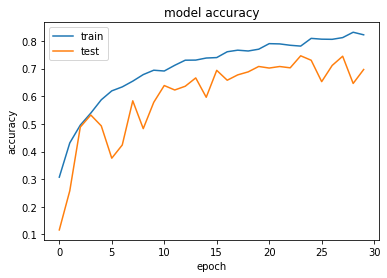

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()